

# AUTOENCODER

Fuente: https://github.com/syorami/Autoencoders-Variants






#### Funciones a usar


In [43]:
# de los autoencoder

import warnings
warnings.filterwarnings('ignore')
import os, datetime
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torchvision
# import data_utils
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable


# de la data_utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision import datasets
from torch.utils import data


# funciones

def load_mnist(BATCH_SIZE=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)) #<-- modificado por error en 3 canales, MNIST es de 1 solo canal
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    print(f'Train Data Shape: {trainset.train_data.numpy().shape}')
    print(f'Test Data Shape: {testset.test_data.numpy().shape}')

    return trainloader, testloader


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [44]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
direccion = '/content/drive/MyDrive/Colab Notebooks/DL/Autoencoder'

### SIMPLE AUTOENCODER

In [103]:
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2),
            #nn.ReLU(inplace=True)
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Tanh()
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def model_training(autoencoder, train_loader, epoch):
    loss_metric = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    autoencoder.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, _ = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_metric(outputs, images)
        loss.backward()
        optimizer.step()
        if (i + 1) % LOG_INTERVAL == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.4f}'.format(
                epoch + 1, EPOCHS, i + 1, len(train_loader.dataset) // BATCH_SIZE, loss.item()
            ))


def evaluation(autoencoder, test_loader):
    total_loss = 0
    loss_metric = nn.MSELoss()
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_metric(outputs, images)
        total_loss += loss * len(images)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))

    global BEST_VAL
    if TRAIN_SCRATCH and avg_loss < BEST_VAL:
        BEST_VAL = avg_loss
        #salvado = os.path.join(path, "User/Desktop", "file.txt")
        torch.save(autoencoder.state_dict(), os.path.join(direccion, "simple_autoencoder_TP.pt"))
        print('Save Best Model in HISTORY\n')

if __name__ == '__main__':

    EPOCHS = 10
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    LOG_INTERVAL = 100
    TRAIN_SCRATCH = True        # whether to train a model from scratch
    BEST_VAL = float('inf')     # record the best val loss

    train_loader, test_loader = load_mnist(BATCH_SIZE)

    autoencoder = Autoencoder()
    if cuda: autoencoder.to(device)

    if TRAIN_SCRATCH:
        # Training autoencoder from scratch
        for epoch in range(EPOCHS):
            starttime = datetime.datetime.now()
            model_training(autoencoder, train_loader, epoch)
            endtime = datetime.datetime.now()
            print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
            # evaluate on test set and save best model
            evaluation(autoencoder, test_loader)
        print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))

    else:
        
        ####
        if cuda:
          autoencoder.load_state_dict(torch.load(os.path.join(direccion, "simple_autoencoder_TP.pt")))
        else:
          autoencoder.load_state_dict(torch.load(os.path.join(direccion, "simple_autoencoder_TP.pt"), map_location=torch.device('cpu')))
        ####
        evaluation(autoencoder, test_loader)

        autoencoder.cpu()
        dataiter = iter(train_loader)
        images, _ = next(dataiter)
        images = Variable(images[:32])
        outputs = autoencoder(images.view(images.size(0), -1))

        # plot and save original and reconstruction images for comparisons
        plt.figure(figsize=(16,8))
        plt.subplot(121)
        plt.title('Original MNIST Images')
        imshow(torchvision.utils.make_grid(images))
        plt.subplot(122)
        plt.title('Autoencoder Reconstruction')
        imshow(torchvision.utils.make_grid(
            outputs.view(images.size(0), 1, 28, 28).data
        ))
        plt.savefig(os.path.join(direccion, "simple_autoencoder_TP.png"))

Train Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)
Epoch [1/10] - Iter[100/468], MSE loss:0.2681
Epoch [1/10] - Iter[200/468], MSE loss:0.2707
Epoch [1/10] - Iter[300/468], MSE loss:0.2659
Epoch [1/10] - Iter[400/468], MSE loss:0.2641
Train a epoch in 14 seconds

Average MSE Loss on Test set: 0.2710
Save Best Model in HISTORY

Epoch [2/10] - Iter[100/468], MSE loss:0.2288
Epoch [2/10] - Iter[200/468], MSE loss:0.2012
Epoch [2/10] - Iter[300/468], MSE loss:0.2014
Epoch [2/10] - Iter[400/468], MSE loss:0.2063
Train a epoch in 14 seconds

Average MSE Loss on Test set: 0.1989
Save Best Model in HISTORY

Epoch [3/10] - Iter[100/468], MSE loss:0.1944
Epoch [3/10] - Iter[200/468], MSE loss:0.1986
Epoch [3/10] - Iter[300/468], MSE loss:0.1934
Epoch [3/10] - Iter[400/468], MSE loss:0.1885
Train a epoch in 14 seconds

Average MSE Loss on Test set: 0.1879
Save Best Model in HISTORY

Epoch [4/10] - Iter[100/468], MSE loss:0.1932
Epoch [4/10] - Iter[200/468], MSE loss:0.1946
Epoch [

### Veamos nuestro modelo, parte por parte

In [104]:
autoencoder.encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Tanh()
)

In [105]:
autoencoder.decoder

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=128, out_features=784, bias=True)
  (5): Tanh()
)

### Analisis del encoder


#### Copiamos el encondoder y copiamos sus pesos sinápticos.

In [106]:
# estamos generando un nuevo model, que copia el sequential del model original, la parte del encoder
encoder = autoencoder.encoder

In [107]:
encoder.load_state_dict(autoencoder.encoder.state_dict())

<All keys matched successfully>

#### le pasamos un "numero" (imagen) a ver como lo codifica

In [108]:
# sacamos un batch del test_loader
img, label = next(iter(test_loader)) 
# pasamos un indice de dicho batch
indice = 1
img = img[indice]
label = label[indice]
# validamos su tamaño
img.shape

torch.Size([1, 28, 28])

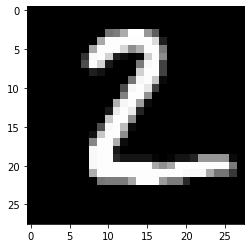

Label: 2


In [109]:
# lo visualizamos
plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Label: {label}")

In [110]:
# para pasarlo a la ENCODER hay que vectorizarlos por que el ENCODER es un MLP
img.view(1, -1).shape

torch.Size([1, 784])

#### pasamos nuestra imagen al ENCODER

In [111]:
num_encoded = encoder(img.view(1, -1))
num_encoded

tensor([[-0.3585,  0.2754]], grad_fn=<TanhBackward0>)

#### mapeo de la representación del los numeros en el latent space

In [112]:
# mapeo el laten space del test
# le pasamos un batch del TEST set y plotemaos la codificación del mismo
img, label = next(iter(test_loader))

# acá le pasamos TODO el batch del TEST al ENCODER, en las dimensiones adecuadas (las
# imagenes de 28x28 son vectorizadas).

latent = encoder(img.view(img.size(0), -1))
# vemos el tamaño de lo que obtuvimos
print('           batch x size')
latent.shape

           batch x size


torch.Size([128, 2])

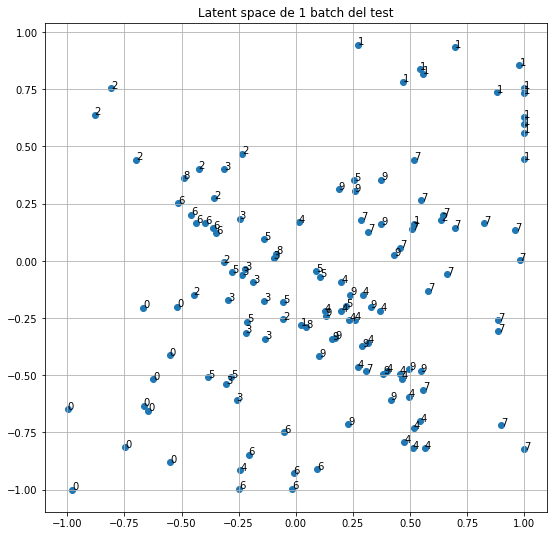

In [113]:
# ploteamos los resultados
fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(latent[:,0].data.cpu(),latent[:,1].data)
# Etiquetamos cada punto para mayor claridad
texts = [ax.text(latent[i,0], latent[i,1], txt.item()) for i, 
      txt in enumerate(label)]

plt.title('Latent space de 1 batch del test')
plt.grid()
plt.show()

### Analisis del decoder

### copiamos el decoder

In [114]:
decoder = autoencoder.decoder

In [115]:
decoder.load_state_dict(autoencoder.decoder.state_dict())

<All keys matched successfully>

#### veamos si le pasamos un rand de [1x2], que ocurre

In [116]:
# generamos el vector de entrada al DECODER
entrada = torch.rand(2)
entrada

tensor([0.4844, 0.4097])

In [117]:
# se lo pasamos al modelo DECODER
est = decoder(entrada)

In [118]:
# vemos le tamaño de la respuesta
est.shape

torch.Size([784])

In [119]:
# lo re-ordenamos y sacamos los valores del tensor (para deshacernos del gradiente)
imagen = est.view(1, 28, 28).data
imagen.shape

torch.Size([1, 28, 28])

In [120]:
type(imagen)

torch.Tensor

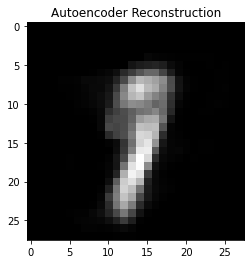

In [121]:
plt.figure()
plt.subplot(111)
plt.title('Autoencoder Reconstruction')
plt.imshow(imagen.squeeze(), cmap="gray")

### Ejercicio

Analizando lo procesado anteriormente y prestando atención a la representación del `latent_space` de batch de TEST ploteado al momento de analizar el encoder, realice un paneo en X e Y del `latent_space` y grafique el resultado que genera el decoder para cada número generado.

Para realizar esto, se deja armada la siguiente celda donde solamente debe fijar los siguientes hiper-parámetros:
- `n` número de imágenes (digits del NMIST) a representar.
- `x_min` valor mínimo de la variable x del `latent_space`.
- `x_max` valor mínimo de la variable x del `latent_space`.
- `y_min` valor mínimo de la variable x del `latent_space`.
- `y_max` valor mínimo de la variable x del `latent_space`.


¿Cómo afecta los límites de x e y del `latent_space` con la última función de activación del encoder? analice el comportamiento modificando dicha función y explique con sus palabras lo que sucede.

### Respuestas
Primero se presentan los hiperparámetros empleados para cada caso empleado de función de activación del encoder.  

**HIPER-PARAMETROS p/función activación encoder ReLU**  
n = 20     
x_min = 0  
x_max = 45      
y_min = 0    
y_max = 50    

**HIPER-PARAMETROS p/función activación encoder Tahn**  
n = 12     
x_min = -1  
x_max = 1      
y_min = -1    
y_max = 1 

En primer lugar lo que se observa es que el los límites del 'latest space' están dados por el dominio de las funciones de activación. Se observa claramente cuando se emplea la función Tahn (ver la última imagen).  
Por último resta destacar que se obtuvo un mejor resultado, no sin ser sustancial, utilizando como función de activación Tahn. 

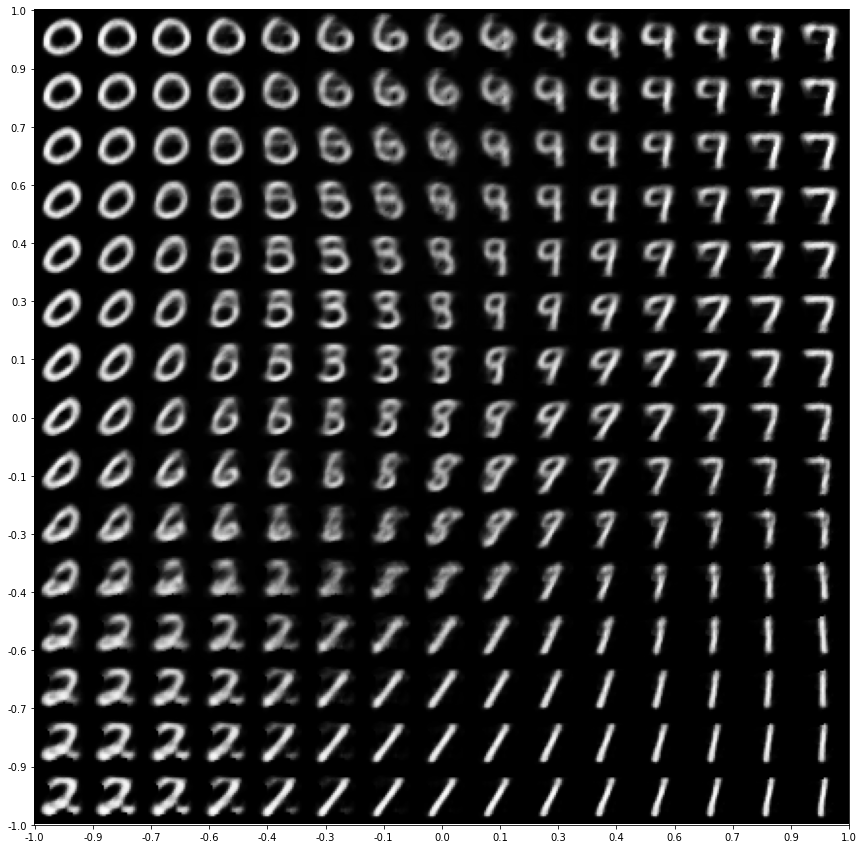

In [125]:
# HIPER-PARAMETROS A FIJAR
n = 15        # número de imágenes (digits del NMIST) a representar.
x_min = -1     # valor mínimo de la variable x del `latent space`.
x_max = 1     # valor mínimo de la variable x del `latent space`.
y_min = -1    # valor mínimo de la variable x del `latent space`.
y_max = 1     # valor mínimo de la variable x del `latent space`.


# Display a 2D manifold of the digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Rangos de evaluación del latent space
grid_x = np.linspace(x_min, x_max, n)
grid_y = np.linspace(y_min, y_max, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.tensor([float(xi), float(yi)])
        x_decoded = decoder(z_sample)
        digit = x_decoded.view(1, 28, 28).data
        figure[(i) * digit_size: (i+1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(figure, cmap="gray")
ax.set_xticks(np.linspace(0,figure.shape[0],n))
ax.set_yticks(np.linspace(0,figure.shape[0],n))
ax.set_xticklabels(np.round(grid_x, decimals=1))
ax.set_yticklabels(np.flip(np.round(grid_y, decimals=1)))
plt.show()
